# 安装包

In [ ]:
#!pip install transformers torch rdkit selfies

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


# 克隆Github上的smiles-gpt仓库
或者上传仓库zip文件，unzip smiles-gpt.zip

In [2]:
!git clone https://github.com/sanjaradylov/smiles-gpt.git

fatal: destination path 'smiles-gpt' already exists and is not an empty directory.


# 导入SMILES-GPT模型和参数

In [3]:
import torch
from transformers import GPT2Config, GPT2LMHeadModel, PreTrainedTokenizerFast

# 设置 GitHub 下载的 checkpoint 目录
checkpoint = "smiles-gpt/checkpoints/benchmark-10m"

# 加载配置
config = GPT2Config.from_pretrained(checkpoint)

# 加载预训练模型
model = GPT2LMHeadModel.from_pretrained(checkpoint)

# 加载 Tokenizer
tokenizer = PreTrainedTokenizerFast.from_pretrained(checkpoint)

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [4]:
tokenizer.add_special_tokens({"bos_token": "<s>"})
model.resize_token_embeddings(len(tokenizer))  # 重新调整嵌入层大小
print(tokenizer.bos_token_id)  # 期望的值应为整数
print(tokenizer.special_tokens_map)  # 检查特殊 token


1
{'bos_token': '<s>'}


# 生成分子

In [5]:
import tqdm

generated_smiles_list = []
n_generated = 10
max_length = 100 # 允许更多探索
top_p = 1.0 # 提高多样性

for _ in tqdm.tqdm(range(n_generated)):
    # Generate from "<s>" so that the next token is arbitrary.
    smiles_start = torch.LongTensor([[tokenizer.bos_token_id]])
    # Get generated token IDs.
    generated_ids = model.generate(smiles_start,
                                   max_length=max_length,
                                   do_sample=True, top_p=top_p,
                                   pad_token_id=tokenizer.eos_token_id)
    # Decode the IDs into tokens and remove "<s>" and "</s>".
    generated_smiles = tokenizer.decode(generated_ids[0],
                                        skip_special_tokens=True)
    generated_smiles_list.append(generated_smiles)

generated_smiles_list

  0%|          | 0/10 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
 20%|██        | 2/10 [00:00<00:00, 15.14it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_to

['CCCCN1C(=O)C(=C2SC(=S)N(CC(=O)[O-])C2=O)c2cc(Br)ccc21',
 'CC(C)(C)c1noc(C2CC[NH+](Cc3cnn(c4ccccc4)c3)CC2)n1',
 'O=C(NCc1ccccc1)C1(C(=O)N2CC3CC(C2)c2cccc(=O)n2C3)CC1',
 'CC(C)CC(NC(=O)c1cccc(Cl)c1)C(=O)NC1CCCN(S(=O)(=O)c2ccccn2)CC1=O',
 'CCOc1cccc2ccc(C[NH2+]C(C)C)nc12',
 'CS(=O)(=O)N1CCC(Nc2nnc(Cl)c3ccccc23)C1',
 'Cc1nc(SC(C)CC(=O)[O-])c2c3c(sc2n1)CCC3',
 'CCOc1ccc2oc(C(=O)NN=Cc3ccc(OCC(=O)Nc4c(C)cccc4C)cc3)c(C)c2c1',
 'CC(C)S(=O)(=O)c1ccc(CC(=O)N2CCSC3(CCC3)C2)cc1',
 'O=C(CCC1NC(=O)N(c2ccc(Cl)cc2)C1=O)NC1CCCCC1']

# 有效性检查

In [6]:
from rdkit import Chem

valid_smiles = [s for s in generated_smiles_list if Chem.MolFromSmiles(s)]
print(f"Valid molecules: {len(valid_smiles)} / {len(generated_smiles_list)}")

Valid molecules: 10 / 10


# 分子可视化

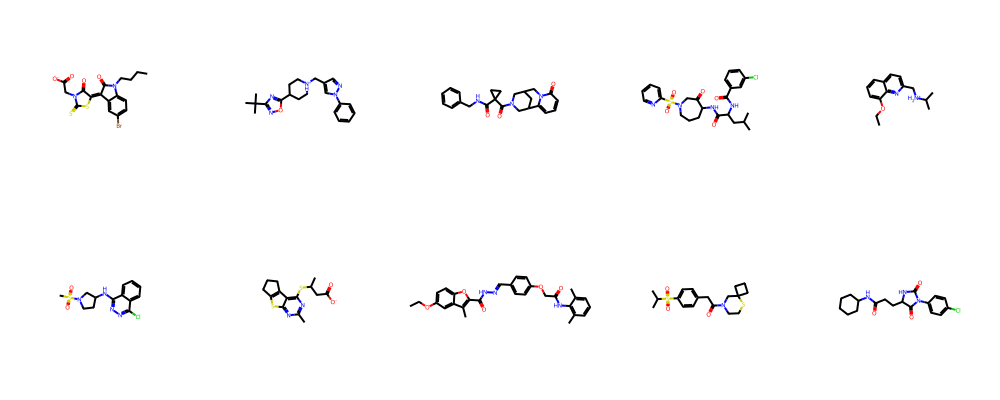

In [7]:
from rdkit.Chem import Draw

mol_list = [Chem.MolFromSmiles(s) for s in valid_smiles[:10]]
Draw.MolsToGridImage(mol_list, molsPerRow=5)